## OPT Trout, 08-01
* MAG 0.5, C mount.
* embedded in 1.5%, 2ECI
* WL transm and FL with blue torch excitation, 590nm LP detections
* 400 steps and undersampling

In [1]:
import sys
import os
import socket
from pathlib import Path
import gc
from time import perf_counter

In [2]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import variance

from tomopy.recon.rotation import find_center_vo, find_center
import tomopy as tom

from data_loader import OptLoader
from correction_class import Correct

# from correction_funcs import apply_corr_dark_bright, apply_corr_int

import ipywidgets as widgets
from IPython.display import display

import utils_opt as u

%load_ext autoreload
%autoreload 2

In [3]:
from napari_opt_handler import corrections

QtBindingsNotFoundError: No Qt bindings could be found

In [4]:
def norm2d(arr):
    mn = np.amin(arr)
    mx = np.amax(arr)
    return ((arr - mn)/(mx-mn)*4095).astype(np.uint16)


def histogram(arr, name, hist_dict=None, bins=256, plot=False):
    hist, bin_edges = np.histogram(arr, bins=bins)
    if plot:
        plt.figure()
        plt.title(name)
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black")
        plt.yscale('log')
        plt.show()
    if hist_dict is not None:
        hist_dict[name] = (hist, bin_edges)
    else:
        hist_dict = {name: (hist, bin_edges)}
    return hist_dict


def plot_histograms(hist_dict):
    plt.figure()
    for name, (hist, bin_edges) in hist_dict.items():
        plt.title(name)
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        # plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), label=name)
        plt.plot(bin_edges[:-1], hist, label=name)
    plt.yscale('log')
    plt.grid()
    plt.legend()
    plt.show()


## FL LP590

In [8]:
root_folder = Path('/opt/shared/opt_paper_david/raw_data/')

In [9]:

# folder = Path('/2024_08_01-fluorescence/2024_08_01-11-36-16_fl_50')
# folder_corr = Path('/2024_08_01-fluorescence')
folder = root_folder.joinpath('2024_08_01-fluorescence/2024_08_01-11-36-16_fl_50')
folder_corr = root_folder.joinpath('2024_08_01-fluorescence')

# no WL correction for FL
# dflat = cv2.imread(str(folder_corr.joinpath('2024_04_05-13-37-20_flat_field.tiff')), cv2.IMREAD_UNCHANGED)
ddark = cv2.imread(str(folder_corr.joinpath('../2024_08_01-transmission/2024_08_01-12-02-29_dark_field.tiff')), cv2.IMREAD_UNCHANGED)
dhot = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-03-54_corr_hot.tiff')), cv2.IMREAD_UNCHANGED)

In [10]:
try:
    u.rename(folder)
except Exception as e:
    print(e)

In [11]:
stride = 1
# Load folder
opt = OptLoader(folder, depth=np.int16, format='tiff')
opt.load_folder(mode='simple', stride=stride)
n_steps, height, width = opt.data.shape

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 223.68it/s]


In [8]:
# widget to select roi
ix0 = widgets.BoundedIntText(value=0, min=0, max=width, step=1, description='x0:', disabled=False)
ix1 = widgets.BoundedIntText(value=1536, min=0, max=width, step=1, description='x1:', disabled=False)
iy0 = widgets.BoundedIntText(value=0, min=0, max=height, step=1, description='y0:', disabled=False)
iy1 = widgets.BoundedIntText(value=2048, min=0, max=height, step=1, description='y1:', disabled=False)

In [9]:
# 360, 1200, y1: 1500
display(ix0), display(ix1)
display(iy0), display(iy1)

# from 25/07/29: 200, 1400, 0, 2047

BoundedIntText(value=0, description='x0:', max=1536)

BoundedIntText(value=1536, description='x1:', max=1536)

BoundedIntText(value=0, description='y0:', max=2048)

BoundedIntText(value=2048, description='y1:', max=2048)

(None, None)

In [10]:
opt.data.shape

(50, 2048, 1536)

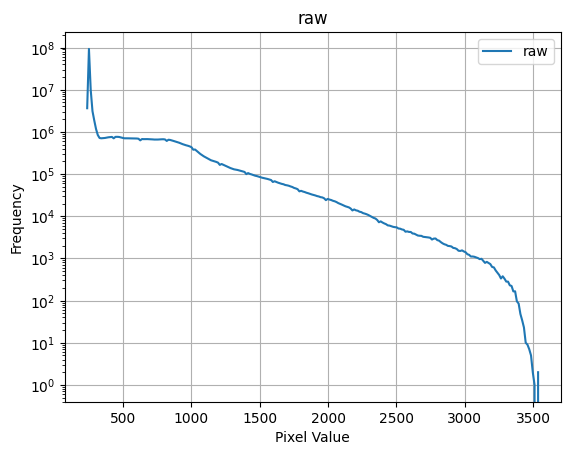

In [11]:
hists = histogram(opt.data, 'raw')
plot_histograms(hists)

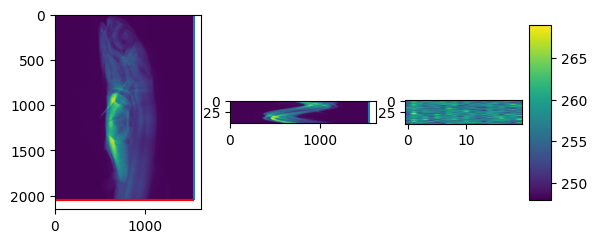

In [12]:
plt.figure()
plt.subplot(131), plt.imshow(opt.data[min(100, n_steps-1)]), plt.gca().set_aspect(1)
plt.vlines(ix0.value, 0, height-1)
plt.vlines(ix1.value, 0, height-1)

plt.hlines(iy0.value, 0, width-1, 'r')
plt.hlines(iy1.value, 0, width-1, 'r')

plt.subplot(132), plt.imshow(opt.data[:, height//2, :]), plt.gca().set_aspect(5)
plt.vlines(ix0.value, 0, n_steps-1)
plt.vlines(ix1.value, 0, n_steps-1)
plt.subplot(133), plt.imshow(opt.data[:, height//2, :20]), plt.colorbar(aspect=8), plt.gca().set_aspect(0.08)
plt.show()

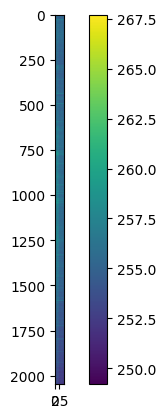

In [13]:
plt.imshow(opt.data[:, :, -10:].mean(axis=2).T)
plt.colorbar()

In [14]:
data = opt.data[:,
                iy0.value:iy1.value,
                ix0.value:ix1.value,
               ]
n_steps, height, width = data.shape

try:
    ddark = ddark[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use DARK')
    
try:
    dhot = dhot[iy0.value:iy1.value,
                ix0.value:ix1.value,]
except NameError:
    print('You probably do not use HOT')
    
try:
    dflat = dflat[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use FLAT')

You probably do not use FLAT


## REsave data

In [15]:
# data2save = u.data2saveFormat(data)
# sys.getsizeof(data2save), data2save.dtype

In [16]:
# with open('../data_output/0801_fl_lp590_400_data_benchmark.npy', 'wb') as f:
#     np.save(f, data2save)

In [17]:
# del data2save

### Cleaning impurities

In [18]:
from skimage.segmentation import find_boundaries, active_contour, chan_vese

In [19]:
def segment_data(arr, mu=0.7):
    out = np.zeros(arr.shape)
    for i, img in tqdm(enumerate(arr)):
        out[i] = img * chan_vese(img, mu=mu)
    return out

In [20]:
# bound1 = find_boundaries(data[0])
# contour1 = chan_vese(data[0], mu=0.7)

In [21]:
# plt.imshow(contour1)
# plt.colorbar()

In [22]:
# plt.plot(contour1[1000])

In [23]:
# data_filt = data[0] * contour1
# plt.imshow(data_filt)
# plt.colorbar()
# plt.show()

# plt.plot(data_filt[1000])
# plt.plot(data[0, 1000])

### Correction

In [24]:
try:
    del Corr
except:
    pass
Corr = Correct(std_mult=7)
Corr.set_dark(dark=ddark)
Corr.set_bad(bad=dhot)

#### Dark-Bright correction

In [25]:
gc.collect()
data_corr = Corr.correct_dark_bright(
                data, modality='Emission', useDark=True, useBright=False)

print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

After Correction max: 3309, min: 0.


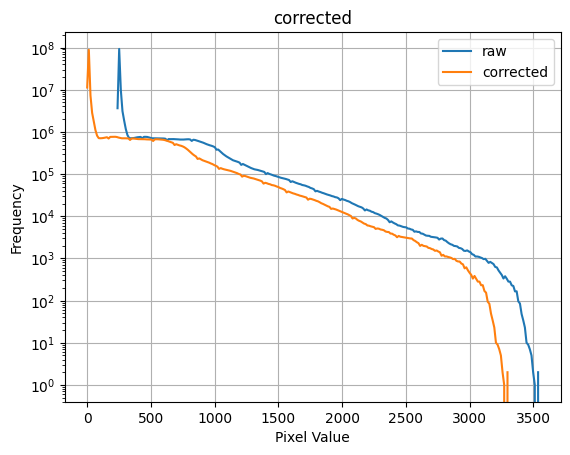

In [27]:
hists = histogram(data_corr, hist_dict=hists, name='corrected')
plot_histograms(hists)

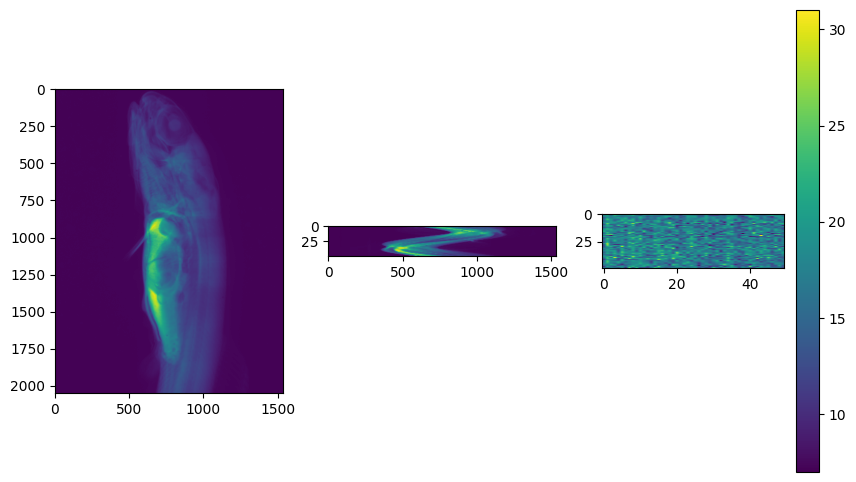

In [28]:
plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(4)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
plt.show()

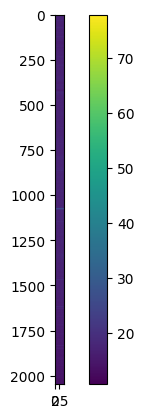

In [29]:
plt.imshow(data_corr[:, :, :10].mean(axis=2).T)
plt.colorbar()

#### Hot pixel correction

In [30]:
Corr.get_bad_pxs()
print(len(Corr.hot_pxs), len(Corr.dead_pxs))

2923 0


In [31]:
def badcorr3D(data):
    out = np.empty(data.shape)
    for i, img in tqdm(enumerate(data)):
        out[i] = Corr.correctBadPxs(img)
    return out

In [32]:
data_corr = badcorr3D(data_corr)

50it [00:01, 32.06it/s]


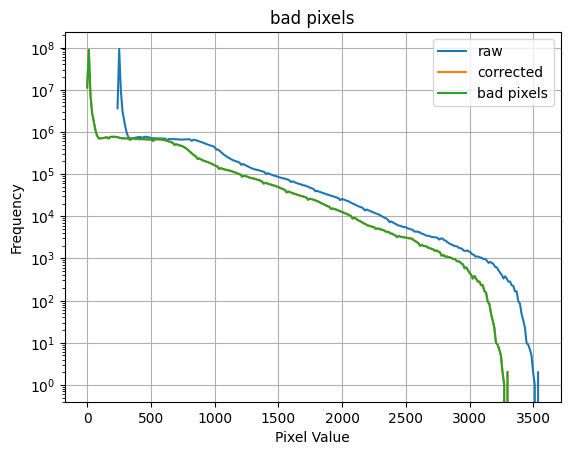

In [33]:
hists = histogram(data_corr, hist_dict=hists, name='bad pixels')
plot_histograms(hists)

In [34]:
print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

After Correction max: 3309.0, min: 0.0.


#### Intensity correction

In [35]:
intCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='Int corr?',
                disabled=False
            )

display(intCorr)

Select(description='Int corr?', options=('Yes', 'No'), rows=2, value='Yes')

Using avg of the corners in the img stack as ref
shape ref: [(50, 50), (50, 50), (50, 50), (50, 50)]


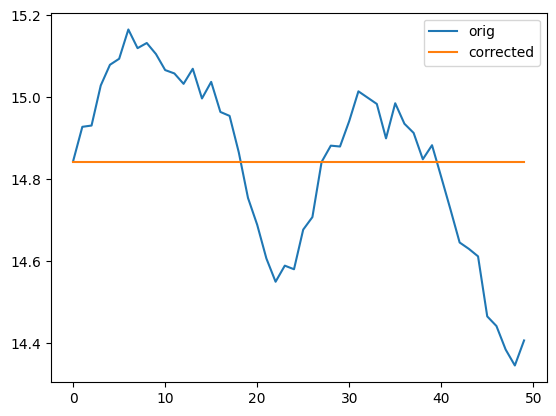

14.841746


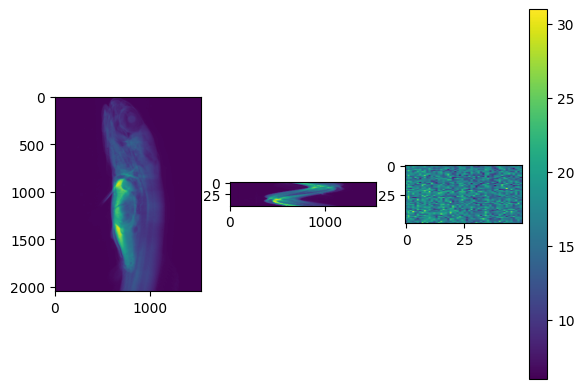

In [37]:
# intensity correction (Without referencing no good for the PL)
if intCorr.value == 'Yes':
    data_corr, report_dict = Corr.correct_int(data_corr, mode='integral',
                                              use_bright=False,
                                              rect_dim=50)
    
    plt.plot(report_dict['stack_orig_int'], label='orig'), 
    plt.plot(report_dict['stack_corr_int'], label='corrected')
    plt.legend()
    plt.show()
    
    print(report_dict['ref'])
    
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(5)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.5), plt.colorbar()
plt.show()

In [38]:
try:
    del data
except:
    print('no data')

try:
    del opt
except:
    print('no opt')

try:
    del full_recon
except:
    print('no full_recon')

n_steps = data_corr.shape[0]
height, width = data_corr.shape[1], data_corr.shape[2]

no full_recon


#### Correcting for FL bleaching

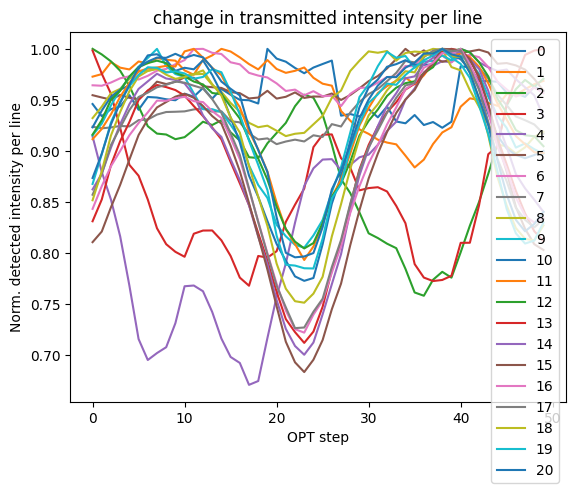

In [39]:
# avoid plotting 1000s of curves
# run this only if you stride in rows a lot
meanOverColumns = data_corr.mean(axis=2).T
if data_corr.shape[1] < 20:
    # I want to see the variation along the sinogram
    for i, sino in enumerate(meanOverColumns):
        plt.plot(sino/max(sino), label=i)
else:
    for i, sino in enumerate(meanOverColumns[::100]):
        plt.plot(sino/max(sino), label=i)


plt.legend()
plt.xlabel('OPT step')
plt.ylabel('Norm. detected intensity per line')
plt.title('change in transmitted intensity per line')
plt.show()

# the same but averaged over all the lines
# plt.plot(meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0)))

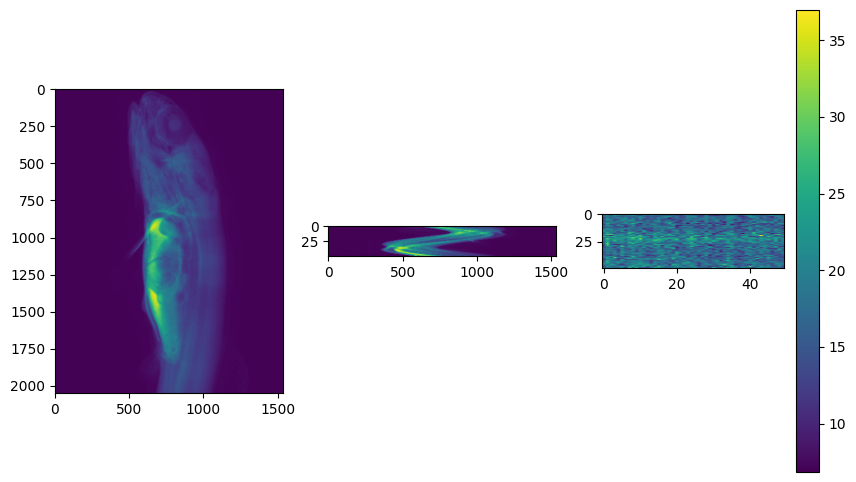

In [40]:
decay = meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0))
data_corr = np.divide(data_corr.T, decay).T

plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :]), plt.gca().set_aspect(4)
plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
plt.show()

### Stride in rows
* reduce dataset

In [41]:
strideRows = widgets.BoundedIntText(
    value=1,
    min=1,
    max=500,
    step=1,
    description='Reduce Rows:',
    disabled=False
)

display(strideRows)

BoundedIntText(value=1, description='Reduce Rows:', max=500, min=1)

In [42]:
if strideRows.value != 1:
    data_corr = data_corr[:, ::strideRows.value, :]
data_corr.shape

(50, 2048, 1536)

In [43]:
del decay
del meanOverColumns
gc.collect()

48652

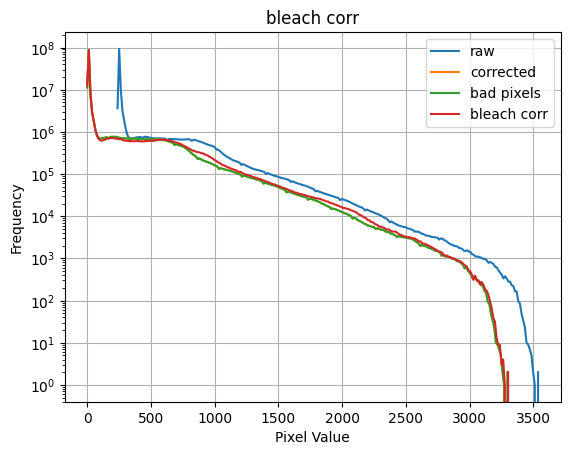

In [46]:
hists = histogram(data_corr, hist_dict=hists, name='bleach corr')
plot_histograms(hists)

### Clip based on the histogram

In [44]:
np.sum(data_corr > 4000), np.amax(data_corr)

(0, 3314.1081867280345)

In [45]:
# plt.hist(data_corr.flatten(), bins=25)
# plt.yscale('log')

In [40]:
# data_corr = np.clip(data_corr, a_min=0, a_max=1150)

In [41]:
# plt.hist(data_corr.flatten(), bins=25)
# plt.yscale('log')

In [42]:
# count zeros in data_corr
print(np.sum(data_corr == 0), np.sum(data_corr < 0))

406 0


### For FL, if something it needs to be log

In [47]:
logCorr = widgets.Select(
                options=['Yes', 'No'],
                value='No',
                rows=2,
                description='log?',
                disabled=False
            )

display(logCorr)

Select(description='log?', index=1, options=('Yes', 'No'), rows=2, value='No')

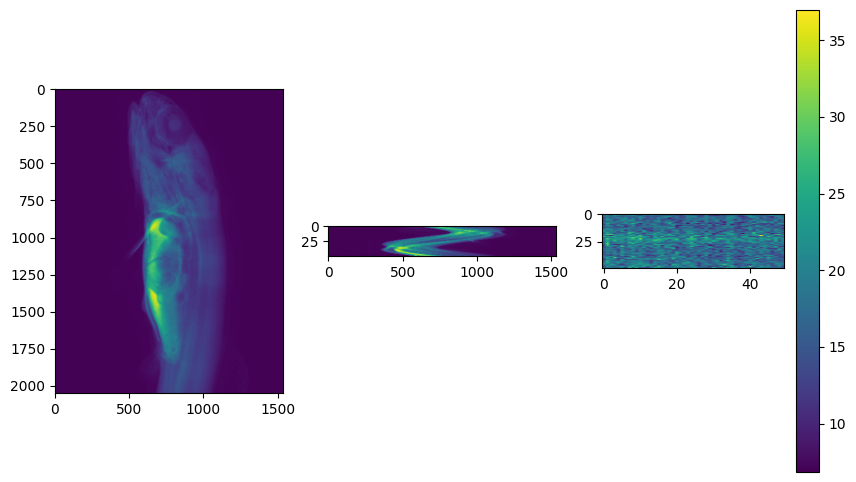

3314.1081867280345 0.0


In [48]:
# intensity correction (Without referencing no good for the PL)
if logCorr.value == 'Yes':
    if np.sum(data_corr == 0):
        print('There are zeros in the data, I replace them with 1.')
        data_corr[data_corr == 0] = 1

    data_corr = np.log10(data_corr)
    data_corr = data_corr - np.amin(data_corr)

plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :]), plt.gca().set_aspect(4)
plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
plt.show()

print(np.amax(data_corr), np.amin(data_corr))

In [49]:
# count infinities
print(np.sum(np.isinf(data_corr)), np.sum(np.isnan(data_corr)))

0 0


In [47]:
# # [397.25, 426.0, 415.5, 401.5, 398.0, 405.5, 406.0, 402.0, 400.0, 399.75, 435.75, 400.75, 400.0]
# print('Reconstruction')
# cor_step = 100
# recon_algo = 'sart'
# print(data_corr.shape)
# full_recon = u.fbp(data_corr, COR='calc', cor_step=cor_step, half_angle=False,
#                    recon_every=1)

In [48]:
# # cut 10% adges
# full_recon = tom.circ_mask(full_recon, axis=0, ratio=0.9)

In [49]:
# height = full_recon.shape[0]
# fig, ax = plt.subplots(5, 3, figsize=(8, 16), sharex=True, sharey=True)
# for i in range(len(full_recon)):
#     try:
#         ax[i//3, i%3].imshow(full_recon[int(height/15*i)], cmap=plt.cm.Greys_r)
#         # ax[i//3, i%3].imshow(full_recon[i], cmap=plt.cm.Greys_r)
#         ax[i//3, i%3].set_title(i)
#     except:
#         pass
# plt.suptitle('400 step Trout-egg, FL LP590')
# plt.tight_layout()
# plt.savefig('../fig_output/0409_trout-egg_fbp_400_fl_lp590.png', dpi=180)
# plt.show()

### FBP CUDA reconstruction

In [50]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
n_steps, height, _ = data_corr.shape
thetas = u.calc_thetas(n_steps, half=False)
np.amax(data_corr), np.amin(data_corr)

(3314.1081867280345, 0.0)

In [51]:
beg = perf_counter()
var_fbp_cuda = []
# cors = np.arange(655, 675, 0.5)
cors = np.arange(775, 783, 0.5)
for cor in cors:
    recon_fbp_cuda = tom.recon(data_corr,
                        thetas,
                        center=cor,
                        algorithm=tom.astra,
                        options=options,
                        ncore=1)
    recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.90)


    var_fbp_cuda.append(np.sum([variance(k) for k in recon_fbp_cuda]))
    print(cor, var_fbp_cuda, end='\r')

end = perf_counter()
print()
print(end-beg)

print(np.argmax(var_fbp_cuda), cors[np.argmax(var_fbp_cuda)])

782.5 [1935.2272020247246, 1860.9959862762028, 1943.4721503721344, 1871.0549855033555, 1955.5167454481125, 1885.6201186113885, 1975.0918400618764, 1910.1330545478395, 2005.104713347223, 1945.7751536700462, 2043.0356335838633, 1980.7516573270161, 2068.2923464708856, 1988.5156600541538, 2056.011452469561, 1957.2769140468704]
258.02312141202856
12 781.0


In [1]:
# recon_fbp_cuda.shape,variance(recon_fbp_cuda)

In [130]:
# variance(recon_fbp_cuda[-1])

### Plot variance of stack

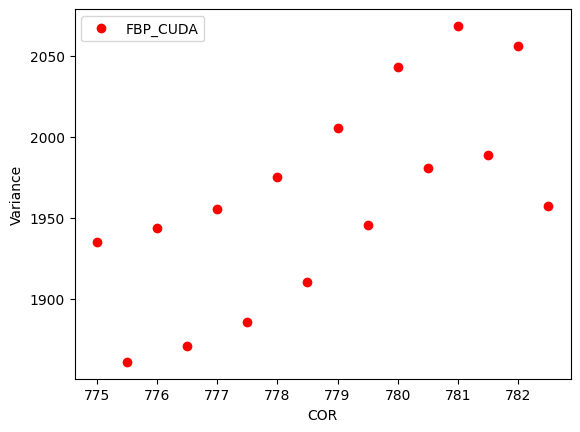

In [52]:
plt.plot(cors, var_fbp_cuda, 'ro', label='FBP_CUDA')
plt.xlabel('COR')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [53]:
beg=perf_counter()
recon_fbp_cuda = tom.recon(data_corr,
                    thetas,
                    center=779,
                    algorithm=tom.astra,
                    options=options,
                    ncore=1)
recon_fbp_cuda = tom.circ_mask(recon_fbp_cuda, axis=0, ratio=0.950)
end = perf_counter()
print(end-beg)

# del data_corr
gc.collect()

11.496271146927029


27862

In [54]:
recon_fbp_cuda.shape, np.amax(recon_fbp_cuda), np.amin(recon_fbp_cuda)

((2048, 1536, 1536), 20.12463, -19.27015)

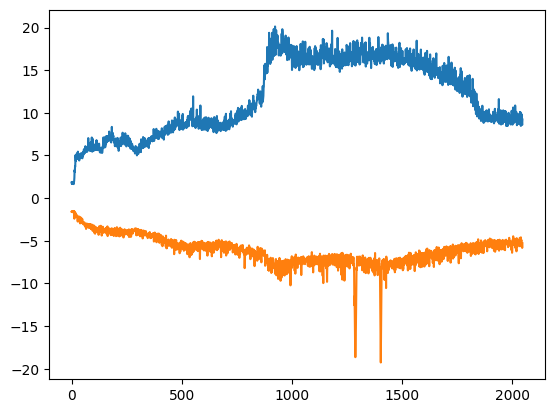

In [55]:
plt.plot(np.amax(recon_fbp_cuda, axis=(1,2)))
plt.plot(np.amin(recon_fbp_cuda, axis=(1,2)))

min max of reconstructions: -19.27015 20.12463


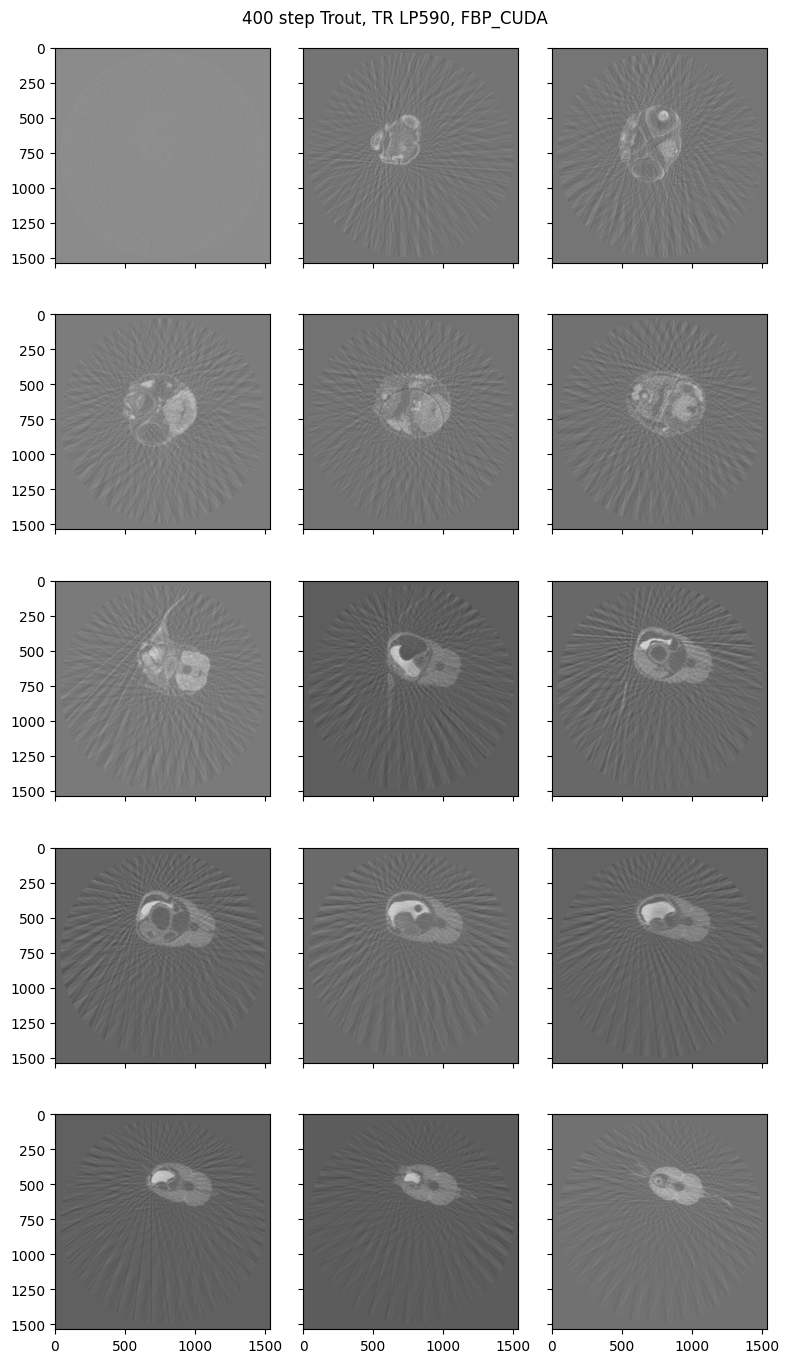

In [56]:
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
lineidx = []
print('min max of reconstructions:',
      np.amin(recon_fbp_cuda),
      np.amax(recon_fbp_cuda))

for i in range(len(recon_fbp_cuda)):
    
    try:
        ax[i//3, i%3].imshow(recon_fbp_cuda[int(height/15*i)], cmap=plt.cm.Greys_r)
        # ax[i//3, i%3].set_title(i)
        lineidx.append(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590.png', dpi=180)
plt.show()

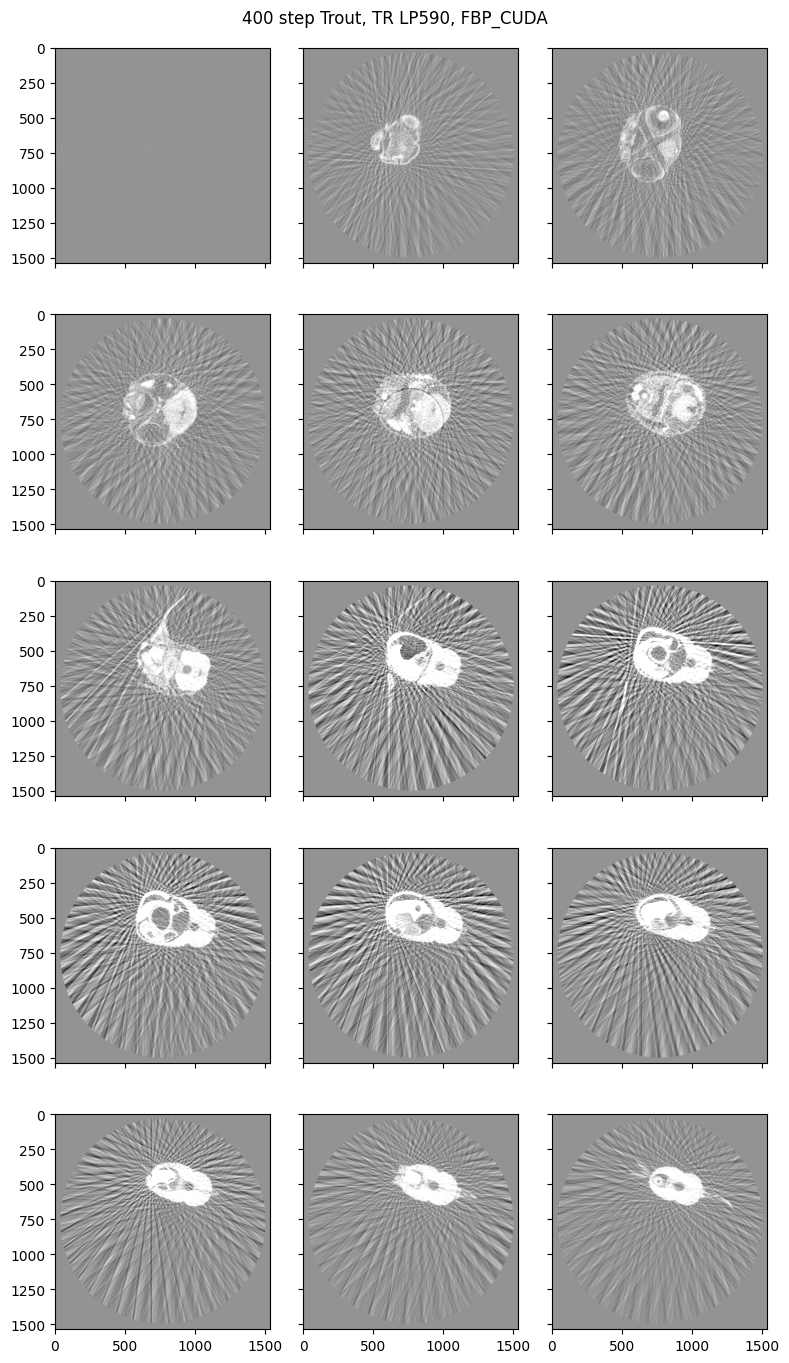

In [57]:
# same but normalize
cmax = np.amax(recon_fbp_cuda)
cmin = np.amin(recon_fbp_cuda)
height = recon_fbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

for i in range(len(recon_fbp_cuda)):
    try:
        ax[i//3, i%3].imshow(recon_fbp_cuda[int(height/15*i)],
                             cmap=plt.cm.Greys_r,
                             vmin=cmin/8, vmax=cmax/8)
        # ax[i//3, i%3].set_title(i)
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
# plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590_same_cscale.png', dpi=180)
plt.show()

### Paper figure

In [51]:
lineidx = [200, 1000, 1500]
# lineidx = [20, 100, 150]
recon_fbp_cuda.shape

(2048, 1536, 1536)

-0.054927453 0.0


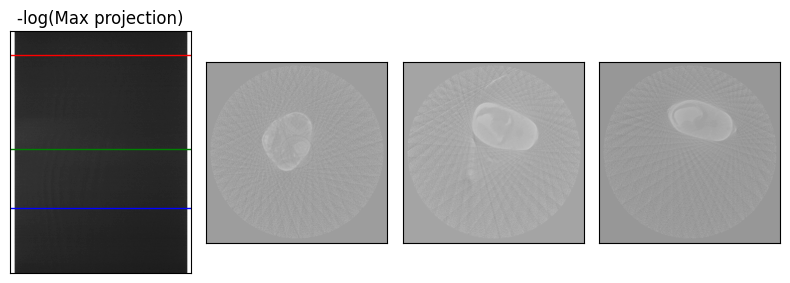

(9.2103405, 3.0095267)

In [54]:
# max projection alone

maxproj= np.max(recon_fbp_cuda, axis=2)
minproj= np.min(recon_fbp_cuda, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(recon_fbp_cuda, axis=2)

# normalization step

data = [recon_fbp_cuda[k] - np.mean(recon_fbp_cuda[k][:50, :50]) for k in lineidx]
data = [norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]



fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)

ax[0].imshow(tom.minus_log(maxproj+0.0001, 2), vmin=3, vmax=9,
             cmap=plt.cm.Greys_r)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper.png', dpi=180)
plt.show()
gc.collect()
np.amax(tom.minus_log(maxproj+0.0001, 2)), np.amin(tom.minus_log(maxproj+0.0001, 2))

-0.054927453 0.0


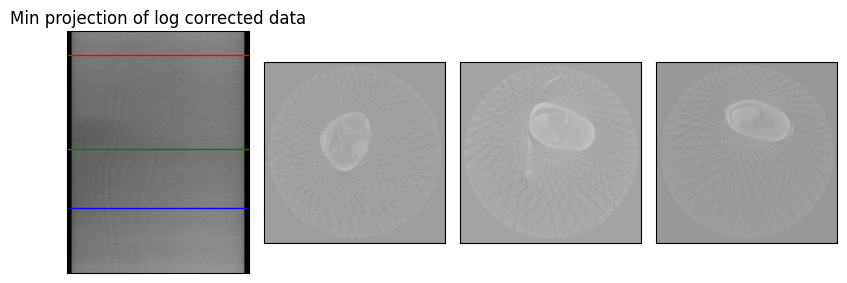

In [ ]:
if logCorr.value == 'Yes':
    maxproj= np.max(recon_fbp_cuda, axis=2)
    minproj= np.min(recon_fbp_cuda, axis=2)
    print(np.amin(minproj), np.amax(minproj))
    meanproj= np.mean(recon_fbp_cuda, axis=2)

    data = [recon_fbp_cuda[k] for k in lineidx]



    fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
    ax[0].imshow(minproj, cmap=plt.cm.Greys)
    ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
    ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
    ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
    ax[0].set_title('Min projection of log corrected data')
    ax[0].set_yticks([])

    ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
    ax[1].set_yticks([])
    ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
    ax[2].set_yticks([])
    ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
    ax[3].set_yticks([])

    plt.xticks([])
    plt.tight_layout()
    # plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_paper.png', dpi=180)
    plt.show()
    gc.collect()

-0.054927453 0.0


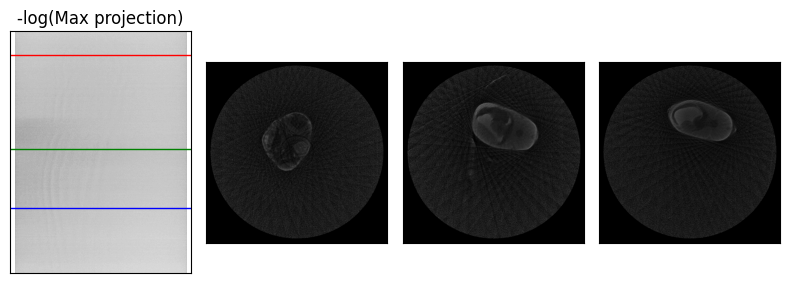

7039

In [53]:
# max projection alone

maxproj= np.max(recon_fbp_cuda, axis=2)
minproj= np.min(recon_fbp_cuda, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(recon_fbp_cuda, axis=2)

# normalization step

data = [recon_fbp_cuda[k] - np.mean(recon_fbp_cuda[k][:50, :50]) for k in lineidx]

data = [np.clip(k, a_min=0, a_max=4095) for k in data]
data = [norm2d(k) for k in data]


fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)

ax[0].imshow(tom.minus_log(maxproj, 2), cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
plt.tight_layout()
# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_paper.png', dpi=180)
plt.show()
gc.collect()

In [225]:
list(print(np.amin(d), np.amax(d), np.mean(d[:50, :50])) for d in data)

0.0 4095.0 0.0
0.0 4095.0 0.0
0.0 4095.0 0.0


[None, None, None]

In [148]:
# save data
data2save = u.data2saveFormat(recon_fbp_cuda)
sys.getsizeof(data2save), data2save.dtype

(8208699408, dtype('int16'))

In [149]:
with open('../data_output/0801_fl_lp590_400_recon.npy', 'wb') as f:
    np.save(f, data2save)

In [150]:
del recon_fbp_cuda

In [151]:
gc.collect()

0

In [152]:
dict2save = {'max_proj': maxproj,
             'lineidx': lineidx,
             'rescaled_cuts': data}

with open('../data_output/0801_fl_lp590_400_recon_paper_data.npy', 'wb') as f:
    np.save(f, data2save)

In [220]:
# height = recon_fbp_cuda.shape[0]
# fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
# lineidx = []

# for i in range(len(recon_fbp_cuda)):
    
#     try:
#         ax[i//3, i%3].imshow(recon_fbp_cuda[int(height/15*i)], cmap=plt.cm.Greys_r)
#         # ax[i//3, i%3].set_title(i)
#         lineidx.append(int(height/15*i))
#     except:
#         pass
# plt.suptitle('400 step Trout, FL LP590, FBP_CUDA')
# plt.tight_layout()
# # plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590.png', dpi=180)
# plt.show()

In [221]:
# # same but normalize
# cmax = np.amax(recon_fbp_cuda)
# cmin = np.amin(recon_fbp_cuda)
# height = recon_fbp_cuda.shape[0]
# fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

# for i in range(len(recon_fbp_cuda)):
#     try:
#         ax[i//3, i%3].imshow(recon_fbp_cuda[int(height/15*i)],
#                              cmap=plt.cm.Greys_r,
#                              vmin=cmin, vmax=cmax/2)
#         # ax[i//3, i%3].set_title(i)
#     except:
#         pass
# plt.suptitle('400 step Trout, FL LP590, FBP_CUDA')
# plt.tight_layout()
# plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590_same_cscale.png', dpi=180)
# plt.show()

In [222]:
# # normalize plus clip negative values
# cmax = np.amax(recon_fbp_cuda)
# cmin = np.amin(recon_fbp_cuda)

# clipped = np.clip(recon_fbp_cuda, a_min=0, a_max=cmax)
# height = recon_fbp_cuda.shape[0]
# fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
# for i in range(len(recon_fbp_cuda)):
#     try:
#         ax[i//3, i%3].imshow(clipped[int(height/15*i)],
#                              cmap=plt.cm.Greys_r,
#                              vmin=cmin, vmax=cmax/2)
#         # ax[i//3, i%3].set_title(i)
#     except:
#         pass
# plt.suptitle('400 step Trout, FL LP590, FBP_CUDA')
# plt.tight_layout()
# plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590_same_cscale_clipped.png', dpi=180)
# plt.show()

In [154]:
gc.collect()

12

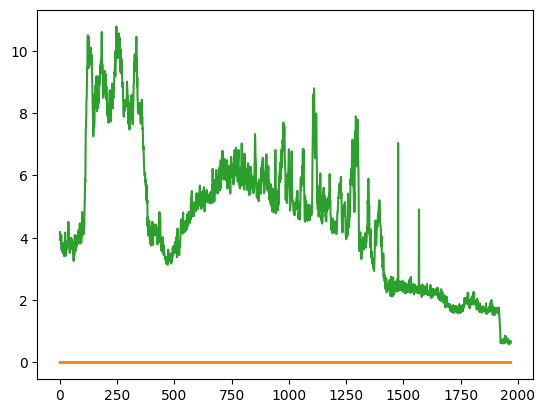

In [56]:
# I need to now how to shift the images
# corner intensities


# np.sum(clipped[:, :50, :50], axis=(1, 2)).shape
# plt.plot(np.mean(clipped[:, :50, :50], axis=(1, 2)))
# plt.plot(np.amin(clipped, axis=(1,2)))
# plt.plot(np.amax(clipped, axis=(1,2)))

nan nan


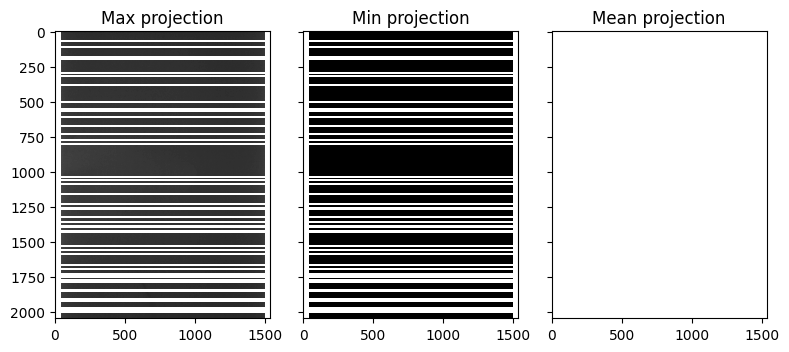

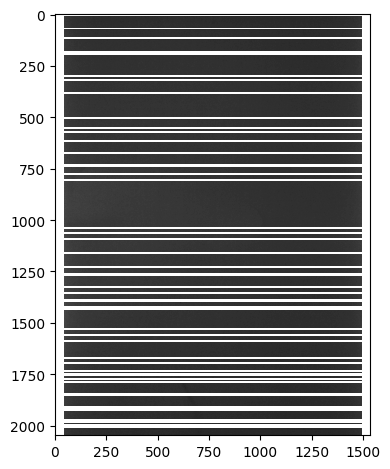

In [227]:
maxproj= np.max(recon_fbp_cuda, axis=2)
minproj= np.min(recon_fbp_cuda, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(recon_fbp_cuda, axis=2)
fig, ax = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(tom.minus_log(maxproj, 2), cmap=plt.cm.Greys_r)
ax[0].set_title('Max projection')
# try:
#     ax[1].imshow(-minproj, cmap=plt.cm.Greys,
#                  vmin= np.amin(-minproj)+ 1,
#                  vmax = np.amax(-minproj)*0.05,
#                  )
# except ValueError:
ax[1].imshow(tom.minus_log(-minproj, 2), cmap=plt.cm.Greys_r,
             vmin= 0,
             vmax = np.amax(-minproj)*0.2,
             )
ax[1].set_title('Min projection')
ax[2].imshow(tom.minus_log(meanproj, 2), cmap=plt.cm.Greys_r)
ax[2].set_title('Mean projection')
plt.tight_layout()
# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_proj.png', dpi=180)
plt.show()

# max projection alone
fig, ax = plt.subplots()#1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax.imshow(tom.minus_log(maxproj, 2), cmap=plt.cm.Greys_r)
# ax[0].set_title('Max projection')
plt.tight_layout()
# plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_max_proj.png', dpi=180)
plt.show()

## Transmission LP590

In [179]:
folder = root_folder.joinpath('2024_08_01-11-45-31')
folder_corr = root_folder.joinpath('Corrections')

dflat = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-01-01_flat_field.tiff')),
                   cv2.IMREAD_UNCHANGED)
ddark = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-02-29_dark_field.tiff')),
                   cv2.IMREAD_UNCHANGED)
dhot = cv2.imread(str(folder_corr.joinpath('2024_08_01-12-03-54_corr_hot.tiff')),
                  cv2.IMREAD_UNCHANGED)

In [180]:
stride = 1
# Load folder
opt = OptLoader(folder, depth=np.int16, format='tiff')
opt.load_folder(mode='simple', stride=stride)
n_steps, height, width = opt.data.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 110.47it/s]


In [181]:
# widget to select roi
ix0 = widgets.BoundedIntText(value=0, min=0, max=width, step=1,
                             description='x0:', disabled=False)
ix1 = widgets.BoundedIntText(value=1416, min=0, max=width, step=1,
                             description='x1:', disabled=False)
iy0 = widgets.BoundedIntText(value=0, min=0, max=height, step=1,
                             description='y0:', disabled=False)
iy1 = widgets.BoundedIntText(value=2047, min=0, max=height, step=1,
                             description='y1:', disabled=False)

In [182]:
# 340, 1180, y1: 1400
display(ix0), display(ix1)
display(iy0), display(iy1)

BoundedIntText(value=0, description='x0:', max=1536)

BoundedIntText(value=1416, description='x1:', max=1536)

BoundedIntText(value=0, description='y0:', max=2048)

BoundedIntText(value=2047, description='y1:', max=2048)

(None, None)

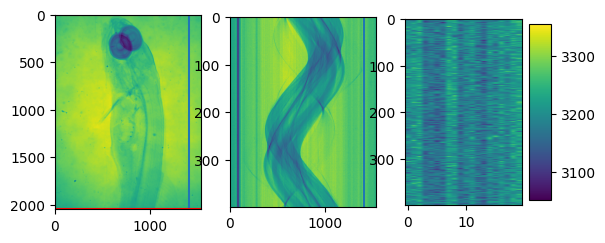

In [183]:
plt.figure()
plt.subplot(131), plt.imshow(opt.data[0])
plt.vlines(ix0.value, 0, height-1)
plt.vlines(ix1.value, 0, height-1)

plt.hlines(iy0.value, 0, width-1, 'r')
plt.hlines(iy1.value, 0, width-1, 'r')

plt.subplot(132), plt.imshow(opt.data[:, height//2, :]), plt.gca().set_aspect(5)
plt.vlines(ix0.value, 0, n_steps-1)
plt.vlines(ix1.value, 0, n_steps-1)
plt.subplot(133), plt.imshow(opt.data[:, height//2, :20]),
plt.colorbar(aspect=8), plt.gca().set_aspect(0.08)
plt.show()

In [184]:
data = opt.data[:,
                iy0.value:iy1.value,
                ix0.value:ix1.value,
               ]
n_steps, height, width = data.shape


In [185]:

try:
    ddark = ddark[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use DARK')
    
try:
    dhot = dhot[iy0.value:iy1.value,
                ix0.value:ix1.value,]
except NameError:
    print('You probably do not use HOT')
    
try:
    dflat = dflat[iy0.value:iy1.value,
                  ix0.value:ix1.value,]
except NameError:
    print('You probably do not use FLAT')

### Saving data

In [186]:
data2save = u.data2saveFormat(data)
sys.getsizeof(data2save), data2save.dtype

(2318841744, dtype('int16'))

In [187]:
with open('../data_output/0801_tr_lp590_400_data_benchmark.npy', 'wb') as f:
    np.save(f, data2save)

In [188]:
del data2save

### Corrections

In [189]:
try:
    del Corr
except:
    pass
gc.collect
Corr = Correct(std_mult=7)
Corr.set_dark(dark=ddark)
Corr.set_bad(bad=dhot)
Corr.set_bright(bright=dflat)

### Dark-Bright correction

In [190]:
data_corr = Corr.correct_dark_bright(
                data, modality='Transmission', useDark=True, useBright=True)

print(f'After Correction max: {np.amax(data_corr)}, min: {np.amin(data_corr)}.')

Overflows 0.17, 1.14, clipping to 0-1.


After Correction max: 65535, min: 11255.


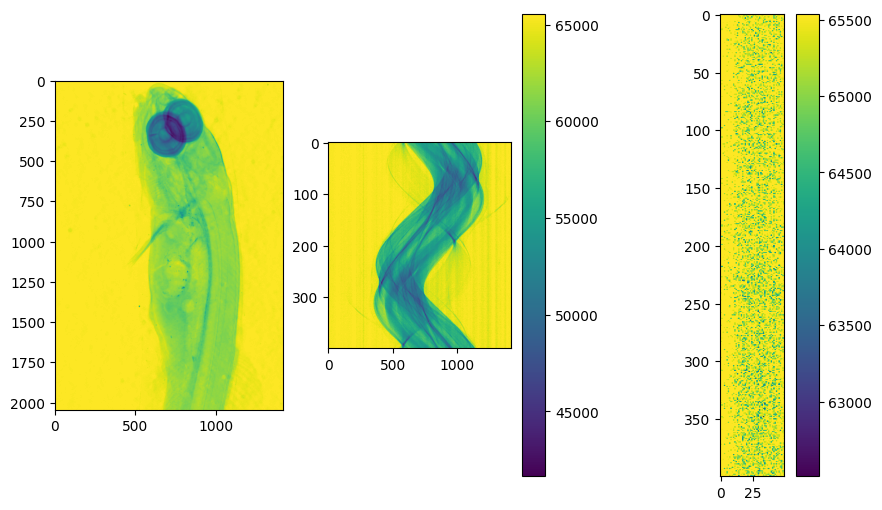

In [191]:
plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(4), plt.colorbar()
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.9), plt.colorbar()
plt.show()

### Intensity correction

In [166]:
intCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='Int corr?',
                disabled=False
            )

display(intCorr)

Select(description='Int corr?', options=('Yes', 'No'), rows=2, value='Yes')

Using avg of the corners in the img stack as ref
shape ref: [(50, 50), (50, 50), (50, 50), (50, 50)]


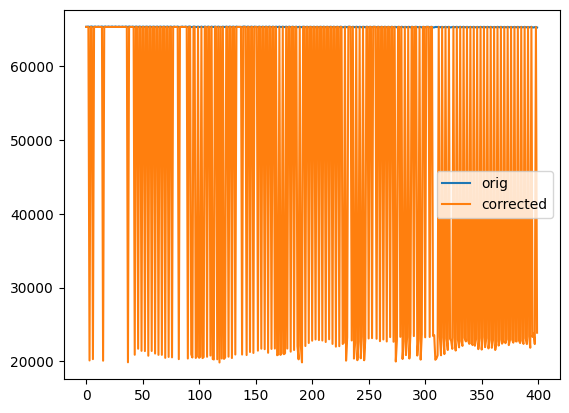

65346.972844


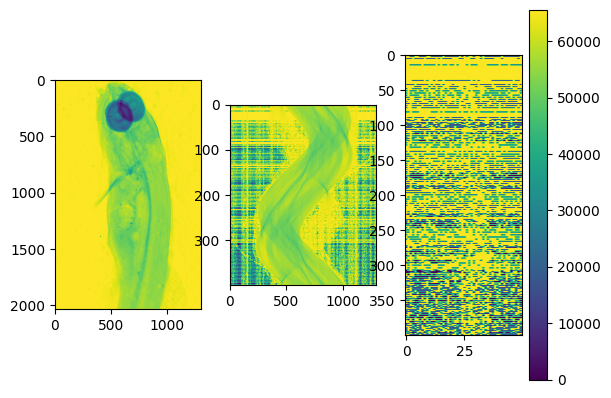

In [237]:
# intensity correction (Without referencing no good for the PL)
if intCorr.value == 'Yes':
    data_corr, report_dict = Corr.correct_int(data_corr, mode='integral',
                                              use_bright=False,
                                              rect_dim=50)
    
    plt.plot(report_dict['stack_orig_int'], label='orig'), 
    plt.plot(report_dict['stack_corr_int'], label='corrected')
    plt.legend()
    plt.show()
    
    print(report_dict['ref'])
    
plt.subplot(131), plt.imshow(data_corr[0])
plt.subplot(132), plt.imshow(data_corr[:, height//2, :]), plt.gca().set_aspect(4)
plt.subplot(133), plt.imshow(data_corr[:, height//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
plt.show()
    
    

In [192]:
try:
    del data
except:
    print('no data')

try:
    del opt
except:
    print('no opt')

try:
    del full_recon
except:
    print('no full_recon')

n_steps = data_corr.shape[0]
height, width = data_corr.shape[1], data_corr.shape[2]

no full_recon


### Stride in rows
* reduce dataset

In [193]:
strideRows = widgets.BoundedIntText(
    value=1,
    min=1,
    max=500,
    step=1,
    description='Reduce Rows:',
    disabled=False
)

display(strideRows)

BoundedIntText(value=1, description='Reduce Rows:', max=500, min=1)

In [194]:
if strideRows.value != 1:
    data_corr = data_corr[:, ::strideRows.value, :]
data_corr.shape

(400, 2047, 1416)

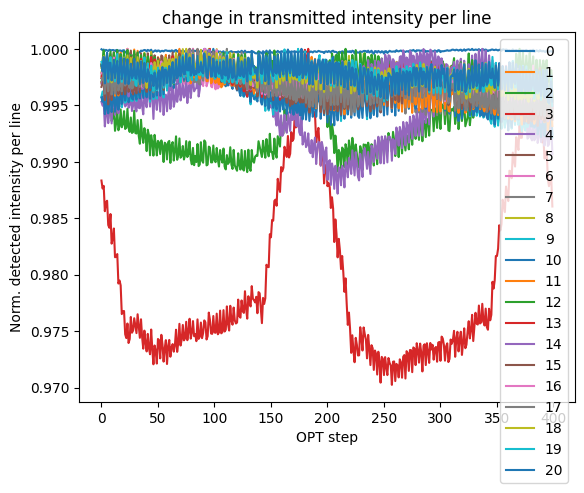

In [195]:
# avoid plotting 1000s of curves
# run this only if you stride in rows a lot
meanOverColumns = data_corr.mean(axis=2).T
if data_corr.shape[1] < 20:
    # I want to see the variation along the sinogram
    for i, sino in enumerate(meanOverColumns):
        plt.plot(sino/max(sino), label=i)
else:
    for i, sino in enumerate(meanOverColumns[::100]):
        plt.plot(sino/max(sino), label=i)


plt.legend()
plt.xlabel('OPT step')
plt.ylabel('Norm. detected intensity per line')
plt.title('change in transmitted intensity per line')
plt.show()

# the same but averaged over all the lines
# plt.plot(meanOverColumns.mean(axis=0)/max(meanOverColumns.mean(axis=0)))

### -log

In [196]:
logCorr = widgets.Select(
                options=['Yes', 'No'],
                value='Yes',
                rows=2,
                description='-log?',
                disabled=False
            )

display(logCorr)

Select(description='-log?', options=('Yes', 'No'), rows=2, value='Yes')

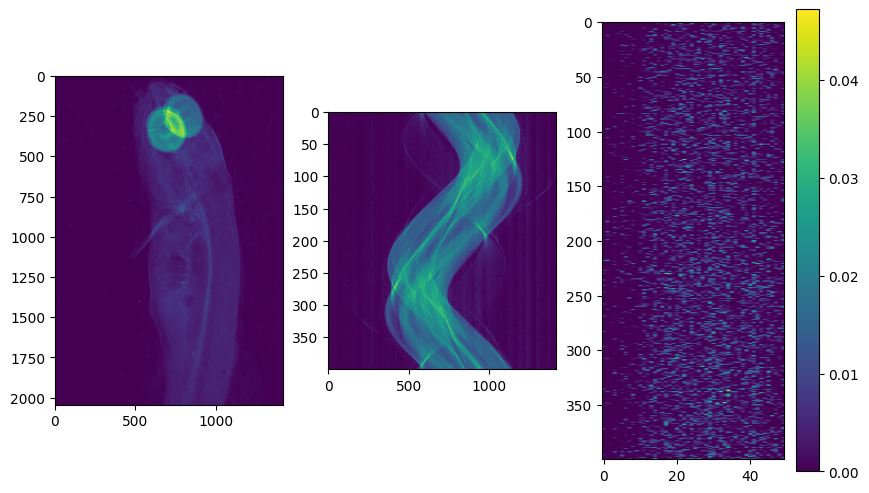

In [197]:
# intensity correction (Without referencing no good for the PL)
if logCorr.value == 'Yes':
    data_corr = tom.minus_log(data_corr, 2)  # two cores
    data_corr = data_corr - np.amin(data_corr)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(131), plt.imshow(data_corr[0])
    plt.subplot(132), plt.imshow(data_corr[:, data_corr.shape[1]//2, :]), plt.gca().set_aspect(4)
    plt.subplot(133), plt.imshow(data_corr[:, data_corr.shape[1]//2, :50]), plt.gca().set_aspect(0.3), plt.colorbar()
    plt.show()

### FBP CUDA reconstruction

In [198]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}
n_steps, height, _ = data_corr.shape
thetas = u.calc_thetas(n_steps, half=False)
np.amax(data_corr), np.amin(data_corr)

(1.7617722, 0.0)

In [281]:
beg = perf_counter()
var_fbp_cuda = []
cors = np.arange(650, 670, 1)


for cor in cors:
    recon_trfbp_cuda = tom.recon(data_corr,
                        thetas,
                        center=cor,
                        algorithm=tom.astra,
                        options=options,
                        ncore=1)
    recon_trfbp_cuda = tom.circ_mask(recon_trfbp_cuda, axis=0, ratio=0.90)


    var_fbp_cuda.append(np.sum([variance(k) for k in recon_trfbp_cuda]))
    print(cor, var_fbp_cuda, end='\r')  

end = perf_counter()
print()
print(end-beg)

print(np.argmax(var_fbp_cuda), cors[np.argmax(var_fbp_cuda)])

669 [0.0003234141836568289, 0.00032355217213420637, 0.0003237277223939958, 0.00032394868133635334, 0.00032422005121818026, 0.0003245289965094526, 0.0003248958033207913, 0.0003253089181989128, 0.0003257785602833981, 0.0003263105165211643, 0.0003268946677042096, 0.0003274839335671832, 0.0003280337911846979, 0.00032863027710428397, 0.00032929062157428725, 0.0003300117585121576, 0.000330797898671264, 0.0003316379644089111, 0.0003325481753017895, 0.0003335259263153175]
5.80135308302124
19 669


In [282]:
recon_trfbp_cuda.shape, variance(recon_trfbp_cuda)

((21, 1296, 1296), 1.588345401113916e-05)

#### Plot variance of stack

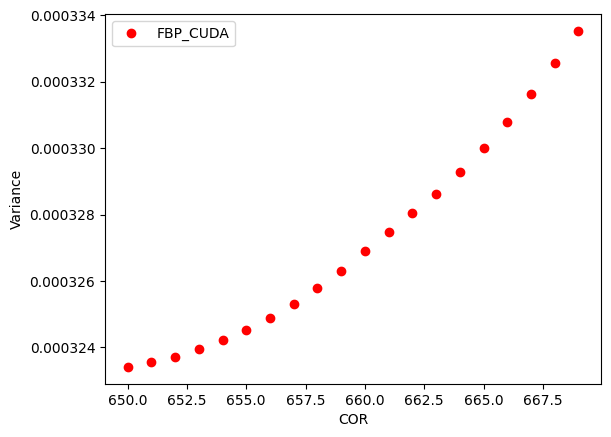

In [283]:
plt.plot(cors, var_fbp_cuda, 'ro', label='FBP_CUDA')
plt.xlabel('COR')
plt.ylabel('Variance')
plt.legend()
plt.show()

### Reconstruction

In [199]:
beg=perf_counter()
recon_trfbp_cuda = tom.recon(data_corr,
                    thetas,
                    center=779,
                    algorithm=tom.astra,
                    options=options,
                    ncore=1)
recon_trfbp_cuda = tom.circ_mask(recon_trfbp_cuda, axis=0, ratio=0.95)

end = perf_counter()
print(end-beg)

del data_corr
gc.collect()

27.113771595002618


39648

min max of reconstructions: -0.011431591 0.082857415


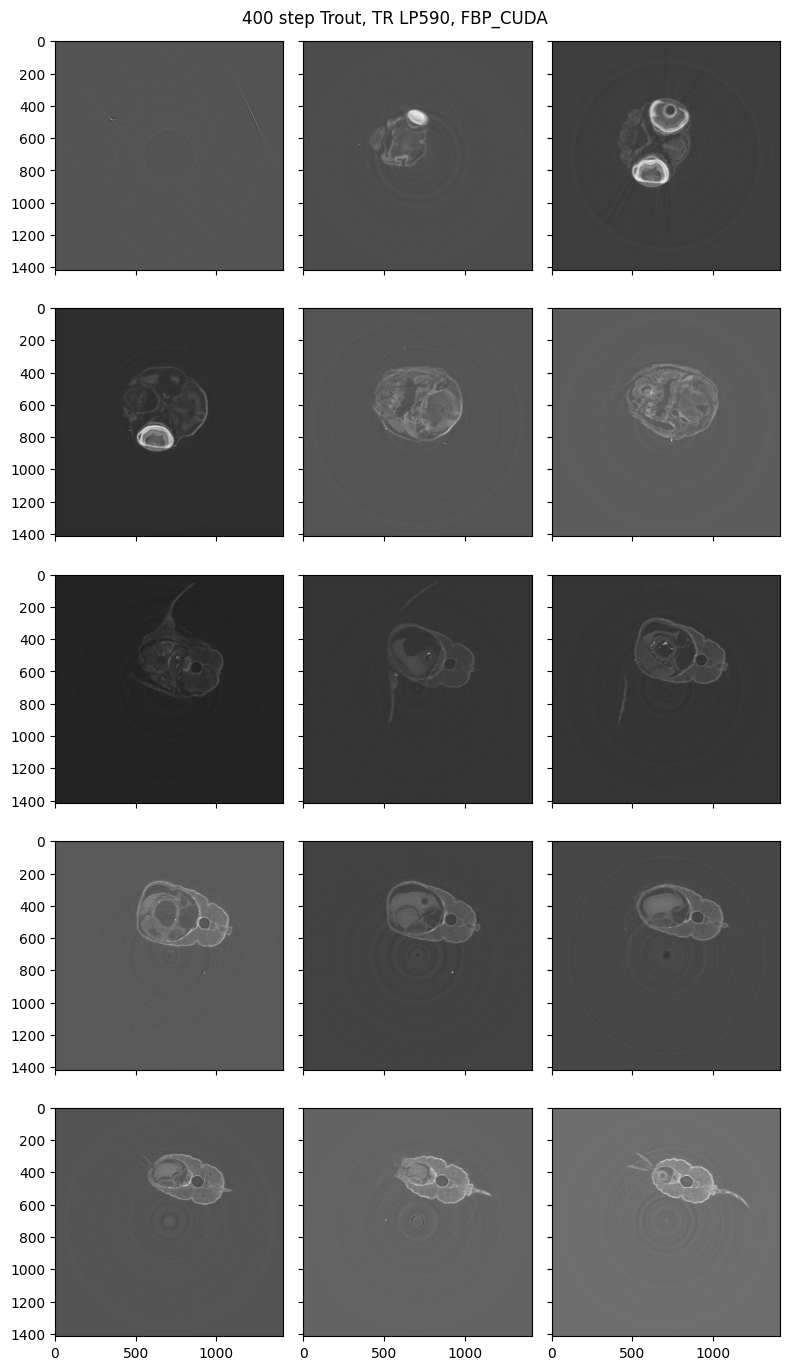

In [200]:
height = recon_trfbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
lineidx = []
print('min max of reconstructions:',
      np.amin(recon_trfbp_cuda),
      np.amax(recon_trfbp_cuda))

for i in range(len(recon_trfbp_cuda)):
    
    try:
        ax[i//3, i%3].imshow(recon_trfbp_cuda[int(height/15*i)], cmap=plt.cm.Greys_r)
        # ax[i//3, i%3].set_title(i)
        lineidx.append(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590.png', dpi=180)
plt.show()

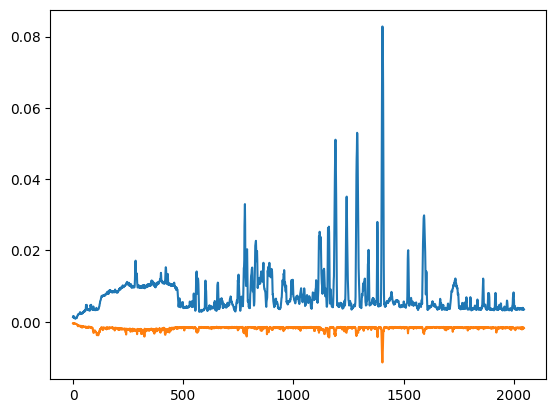

In [201]:
plt.plot(np.amax(recon_trfbp_cuda, axis=(1,2)))
plt.plot(np.amin(recon_trfbp_cuda, axis=(1,2)))

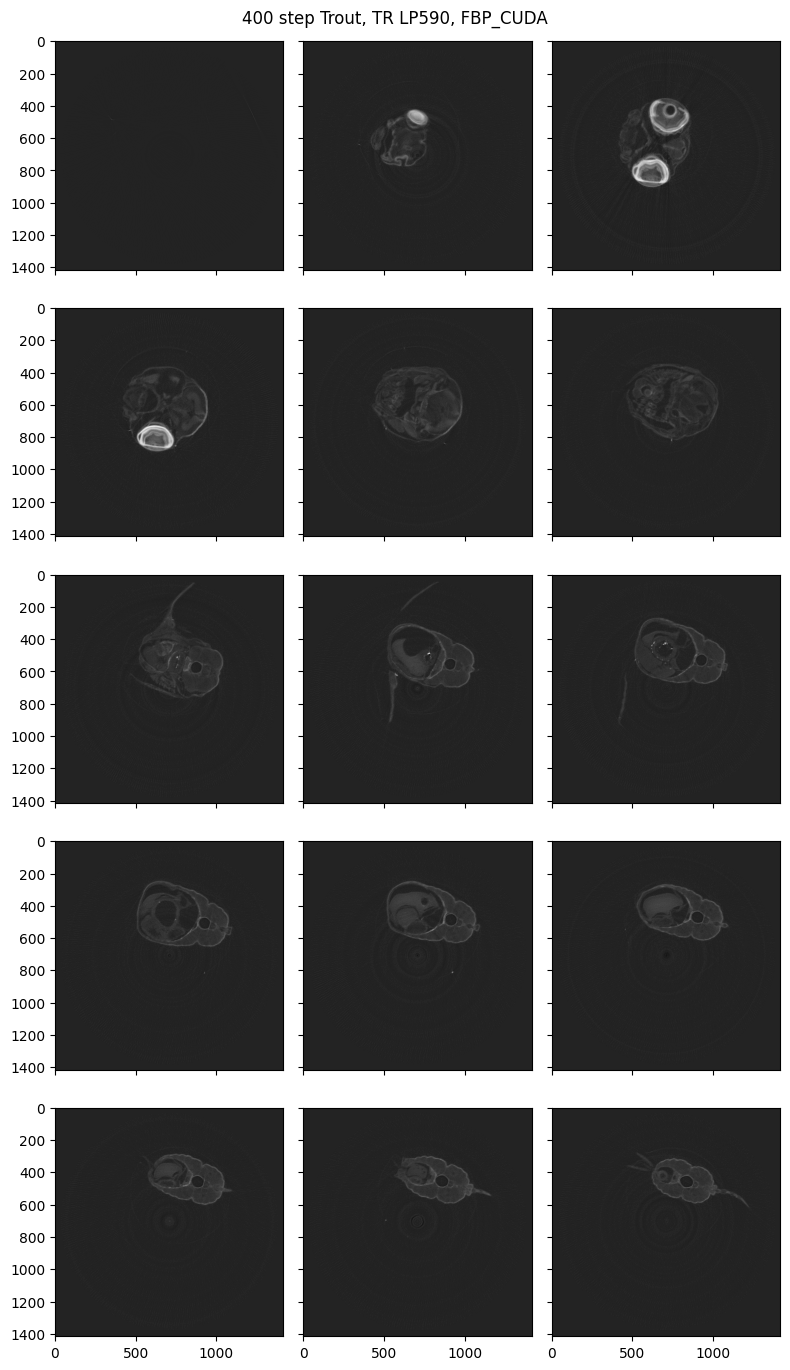

In [203]:
# same but normalize
cmax = np.amax(recon_trfbp_cuda)
cmin = np.amin(recon_trfbp_cuda)
height = recon_trfbp_cuda.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)

for i in range(len(recon_trfbp_cuda)):
    try:
        ax[i//3, i%3].imshow(recon_trfbp_cuda[int(height/15*i)],
                             cmap=plt.cm.Greys_r,
                             vmin=cmin/8, vmax=cmax/8)
        # ax[i//3, i%3].set_title(i)
    except:
        pass
plt.suptitle('400 step Trout, TR LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0725_trout_fbp-cuda_400_fl_lp590_same_cscale.png', dpi=180)
plt.show()

### Paper figure

In [204]:
if len(recon_trfbp_cuda) > 20:
    lineidx = [200, 1000, 1500]
else:
    lineidx = [3, 6, 9]

# del recon_fbp_cuda
recon_trfbp_cuda.shape

(2047, 1416, 1416)

-0.011431591 0.0


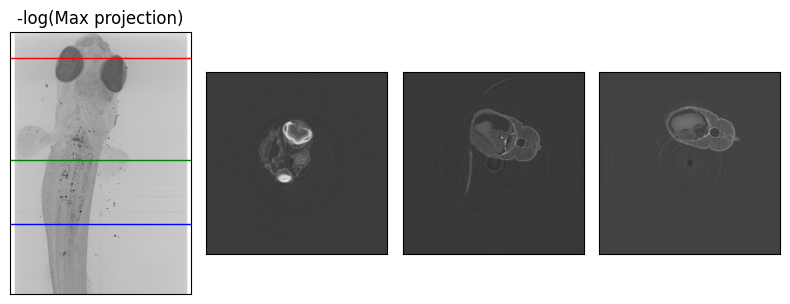

(9.2103405, 2.4894278)

In [205]:
# max projection alone

maxproj= np.max(recon_trfbp_cuda, axis=2)
minproj= np.min(recon_trfbp_cuda, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(recon_trfbp_cuda, axis=2)

# normalization step

data = [recon_trfbp_cuda[k] - np.mean(recon_trfbp_cuda[k][:50, :50]) for k in lineidx]
data = [norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]



fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)

ax[0].imshow(tom.minus_log(maxproj+0.0001, 2), vmin=3, vmax=9,
             cmap=plt.cm.Greys_r)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper.png', dpi=180)
plt.show()
gc.collect()
np.amax(tom.minus_log(maxproj+0.0001, 2)), np.amin(tom.minus_log(maxproj+0.0001, 2))

In [206]:
list(print(np.amin(d), np.amax(d), np.mean(d[:50, :50])) for d in data)

0.0 4095.0 773.09656
0.0 4095.0 740.9092
0.0 4095.0 852.0721


[None, None, None]

## Saving data

In [207]:
# save data
data2save = u.data2saveFormat(recon_trfbp_cuda)
sys.getsizeof(data2save), data2save.dtype

(8208699408, dtype('int16'))

In [208]:
with open('../data_output/0801_tr_lp590_400_recon.npy', 'wb') as f:
    np.save(f, data2save)

In [209]:
del recon_trfbp_cuda

In [210]:
gc.collect()

0

In [211]:
dict2save = {'max_proj': maxproj,
             'lineidx': lineidx,
             'rescaled_cuts': data}

with open('../data_output/0801_tr_lp590_400_recon_paper_data.npy', 'wb') as f:
    np.save(f, data2save)

### FL - TR

In [212]:
tr = np.load('../data_output/0801_tr_lp590_400_recon.npy', allow_pickle=True)
fl = np.load('../data_output/0801_fl_lp590_400_recon.npy', allow_pickle=True)

In [213]:
np.amax(tr), np.amin(tr), np.amax(fl), np.amin(fl)  

(4095, 0, 4095, 0)

In [214]:
tr.shape == fl.shape
diff = tr - fl
np.amax(diff), np.amin(diff)

(2030, -3573)

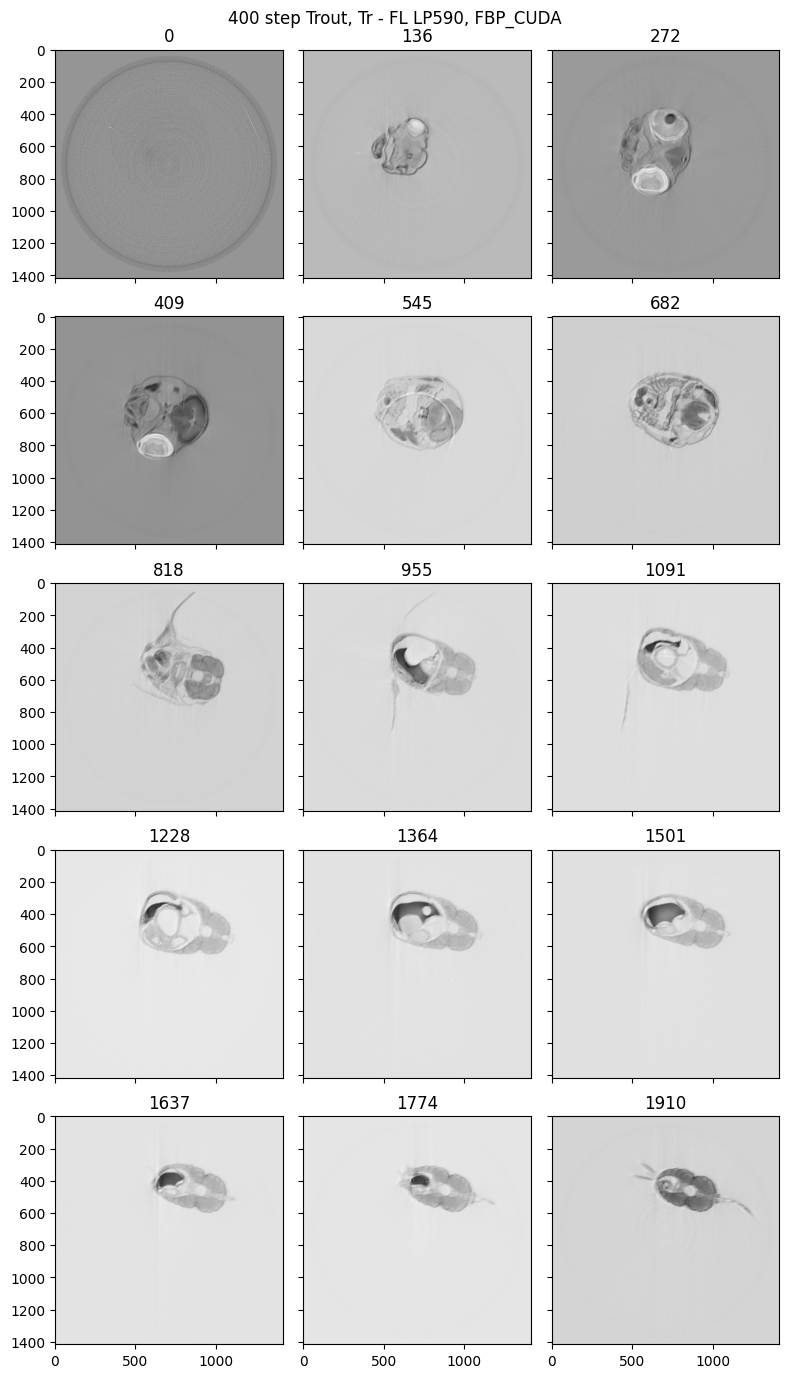

In [296]:
height = tr.shape[0]
fig, ax = plt.subplots(5, 3, figsize=(8, 14), sharex=True, sharey=True)
for i in range(len(tr)):
    try:
        ax[i//3, i%3].imshow(diff[int(height/15*i)], cmap=plt.cm.Greys_r)
        # for the case of stride in rows and plotting everything
        # ax[i//3, i%3].imshow(full_recon[i], cmap=plt.cm.Greys_r)
        ax[i//3, i%3].set_title(int(height/15*i))
    except:
        pass
plt.suptitle('400 step Trout, Tr - FL LP590, FBP_CUDA')
plt.tight_layout()
plt.savefig('../fig_output/0801_tr_fl_diff.png', dpi=180)
plt.show()

### Difference figure for paper from loaded data

In [297]:
lineidx = [688, 955, 1637]
tr.shape

# max projection alone
maxproj= np.max(tr-fl, axis=2)
minproj= np.min(tr-fl, axis=2)
print('max', np.amin(maxproj), np.amax(maxproj))
print('min', np.amin(minproj), np.amax(minproj))
meanproj= np.mean(tr-fl, axis=2)
# normalization step

data = [tr[k]-fl[k] - np.mean((tr[k]-fl[k])[:50, :50]) for k in lineidx]
data = [norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]

max -1791 2030
min -3573 -1791


2030 -1791


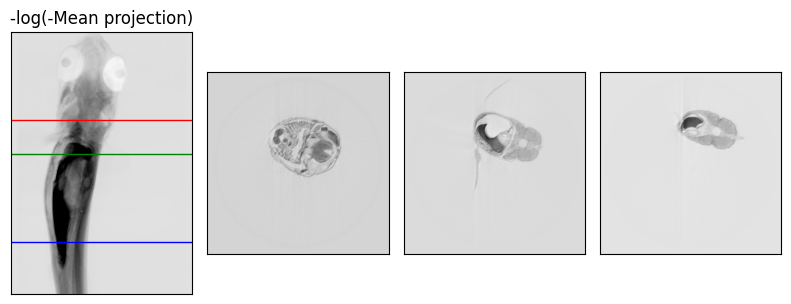

-7.621397 -7.4726887


47286

In [298]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(maxproj),
      np.amin(maxproj))
# ax[0].imshow(meanproj,
#              # vmax=0.5,
#              # vmin=-20,
#              cmap=plt.cm.Greys_r)

ax[0].imshow(tom.minus_log(-meanproj, 2),
             vmin=-7.56,
             # vmax=9,
             cmap=plt.cm.Greys_r)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(-Mean projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr-fl_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
print(
np.amin(tom.minus_log(-meanproj, 2)),
np.amax(tom.minus_log(-meanproj, 2)))
gc.collect()

### Transmission figure for paper from loaded data

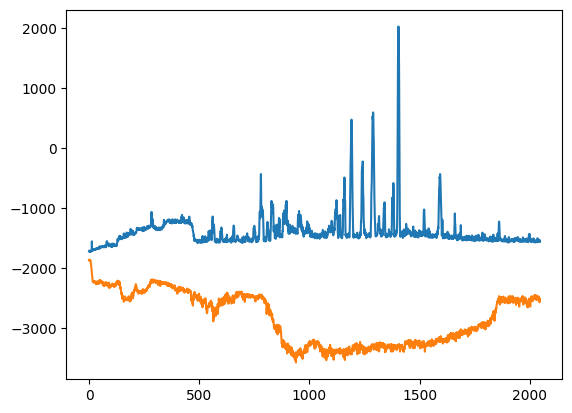

In [238]:
plt.plot(np.amax(tr-fl, axis=(1,2)))
plt.plot(np.amin(tr-fl, axis=(1,2)))

max 496 4095
min 0 496
-6.206576 -8.317522


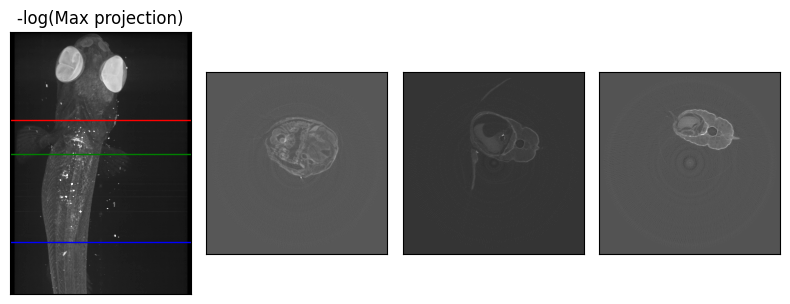

7039

In [299]:
lineidx = [688, 955, 1637]
tr.shape

# max projection alone
maxproj= np.max(tr, axis=2)
minproj= np.min(tr, axis=2)
print('max', np.amin(maxproj), np.amax(maxproj))
print('min', np.amin(minproj), np.amax(minproj))
meanproj= np.mean(tr, axis=2)
# normalization step

data = [tr[k] - np.mean(tr[k][:50, :50]) for k in lineidx]
data = [norm2d(k) for k in data]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]

fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(tom.minus_log(maxproj, 2)),
      np.amin(tom.minus_log(maxproj, 2)))
ax[0].imshow(tom.minus_log(maxproj, 2),
             # vmin=500,
             vmin=-7,
             cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_tr_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
gc.collect()

### FL paper image from loaded data

0 2287
-7.7349963 -8.317522


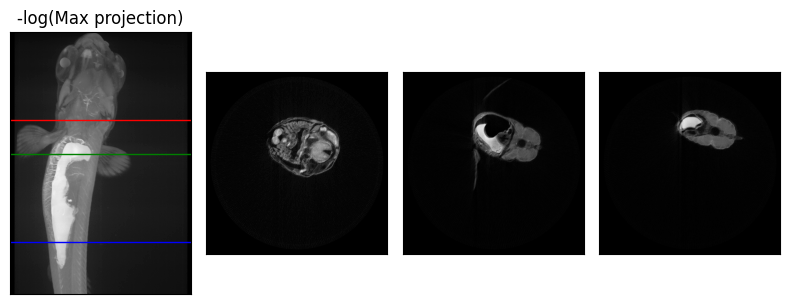

7039

In [300]:
lineidx = [688, 955, 1637]
fl.shape

# max projection alone
maxproj= np.max(fl, axis=2)
minproj= np.min(fl, axis=2)
print(np.amin(minproj), np.amax(minproj))
meanproj= np.mean(fl, axis=2)
# normalization step

data = [fl[k] - np.mean(fl[k][:50, :50]) for k in lineidx]
data = [np.clip(k, a_min=0, a_max=4095) for k in data]
data = [norm2d(k) for k in data]

fig, ax = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=False)
print(np.amax(tom.minus_log(maxproj, 2)), np.amin(tom.minus_log(maxproj, 2)))
ax[0].imshow(tom.minus_log(maxproj, 2), cmap=plt.cm.Greys)
ax[0].axhline(lineidx[0], color='r', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[1], color='g', lw=1, label='_nolegend_')
ax[0].axhline(lineidx[2], color='b', lw=1, label='_nolegend_')
ax[0].set_title('-log(Max projection)')
ax[0].set_yticks([])

ax[1].imshow(data[0], cmap=plt.cm.Greys_r)
ax[1].set_yticks([])
ax[2].imshow(data[1], cmap=plt.cm.Greys_r)
ax[2].set_yticks([])
ax[3].imshow(data[2], cmap=plt.cm.Greys_r)
ax[3].set_yticks([])

plt.xticks([])
# plt.colorbar(om, ax[3])
plt.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.savefig('../fig_output/0801_trout_fbp-cuda_400_fl_lp590_paper01.png', dpi=180, bbox_inches='tight')
plt.show()
gc.collect()